In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

import torchvision
import torchvision.datasets as dset
from torchvision import transforms, models
import os
from os import listdir
from os.path import isfile, join
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from skimage import transform
from skimage.io import imread
from sklearn import preprocessing

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
#setting folder
folder='data/'
print('number of images: {}'.format(len(os.listdir(folder))))
# Switching on GPU
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is {}".format(device))

number of images: 1122
device is cuda


In [4]:
class FoodDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder=folder
        
    def __len__(self):
        return len(listdir(self.folder))
    
    def __getitem__(self, index):       
        #Create dataframe with name of image, target and it's id
        images=pd.DataFrame(os.listdir(self.folder), columns=['img_name'])
        images['label']=images['img_name'].map(lambda x: str(x).split('_')[0])
        encoder={'pizza':0,'pasta':1,'burger':2,'hotdog':3}
        images['target']=images['label'].map(encoder)
        images['img_id']=images['img_name'].map(lambda x: str(x).split('.')[0])

        #One-hot classes for association
        images['italian']=np.where(images['label'].isin(['pizza','pasta']),1,0)
        images['american']=np.where(images['label'].isin(['burger','hotdog']),1,0)
        images['pizza']=np.where(images['label']=='pizza',1,0)
        images['burger']=np.where(images['label']=='burger',1,0)
        
        multiclass_targets=images[['italian','american','pizza','burger']].as_matrix()
        
        
        img_name=os.path.join(self.folder, images.iloc[index,0])
        img=Image.open(img_name)
        target=images.iloc[index,2]
        img_id=images.iloc[index,1]
        multiclass_target=multiclass_targets[index]
        
        if self.transform:
            img = self.transform(img)
        
        return img, target, multiclass_target, img_id 
    
orig_dataset = FoodDataset(folder)

In [5]:
def visualize_samples(dataset, indices, count=5):
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    for i, index in enumerate(display_indices):    
        x, y, y_mc, img_id = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title('label: {}, oh: {}'.format(img_id,y_mc))
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   

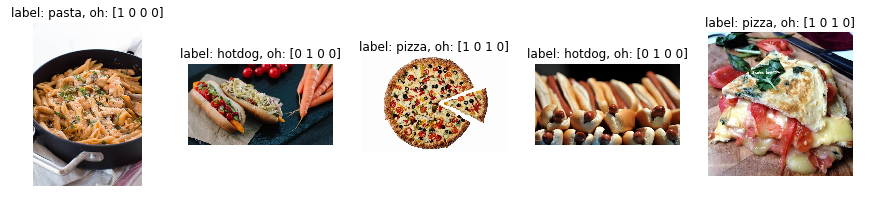

In [6]:
indices = np.random.choice(np.arange(len(orig_dataset)), 5, replace=False)
visualize_samples(orig_dataset, indices)

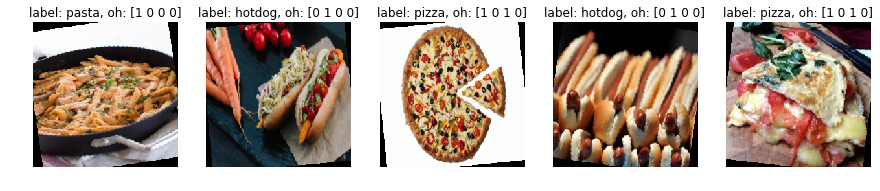

In [7]:
transformed_dataset=FoodDataset(folder, transform=transforms.Compose([
                                    transforms.Resize((224,224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation((-10,10))
                                                                    ]))
visualize_samples(transformed_dataset, indices)

In [8]:
# Setting dataset
dataset=FoodDataset(folder, transform=transforms.Compose([
                                    transforms.Resize((224,224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation((-10,10)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))                         
                                                        ]))

# Deviding train dataset into train and validation
bs=8
np.random.seed(42)
data_size=len(dataset)
split=int(np.floor(0.2*data_size))
data_indices=list(range(data_size))
np.random.shuffle(data_indices)
train_indices, val_indices=data_indices[split:], data_indices[:split]
train_sampler=SubsetRandomSampler(train_indices)
val_sampler=SubsetRandomSampler(val_indices)

# DataLoading
train_loader=torch.utils.data.DataLoader(dataset, batch_size=bs, sampler=train_sampler)
val_loader=torch.utils.data.DataLoader(dataset, batch_size=bs, sampler=val_sampler)

# Simple Classifier

In [12]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epoch=10):
    loss_history=[]
    train_history=[]
    val_history=[]
    for epoch in range(num_epoch):
        model.train()
        loss_accum=0
        correct_samples=0
        total_samples=0
        
        for i_step, (x,y,y_oh,label) in enumerate(train_loader):
            x,y=x.to(device),y.to(device)
            prediction=model(x)
            loss_value=loss(prediction,y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices=torch.max(prediction, 1)
            correct_samples+=torch.sum(indices==y)
            total_samples+=y.shape[0]
            
            loss_accum+=loss_value
            
        scheduler.step()                    
        ave_loss=loss_accum/i_step
        train_accuracy=float(correct_samples)/total_samples
        val_accuracy=compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print('Epoch: {}/{}, Train_loss: {}, Train_accuracy: {}, Val_accuracy: {}'.format(epoch+1,num_epoch,
                                                                    ave_loss,train_accuracy,val_accuracy))
    return loss_history, train_history, val_history

def compute_accuracy(model,loader):
    model.eval()
    correct_samples=0
    total_samples=0
    
    for i_step, (x,y,y_oh,label) in enumerate(loader):
        x,y=x.to(device),y.to(device)
        prediction=model(x)
        _,indices=torch.max(prediction,1)
        correct_samples+=torch.sum(indices==y)
        total_samples+=y.shape[0]
        
    accuracy=float(correct_samples)/total_samples
    return accuracy

In [13]:
# My model
net=models.resnet18(pretrained=True)
num_ftrs=net.fc.in_features
net.fc=nn.Linear(num_ftrs,4)

net.load_state_dict(torch.load('classifier.pt'))
net=net.to(device)

loss=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=1e-3, momentum=0.9)
scheduler=StepLR(optimizer,step_size=10, gamma=0.1)

loss_history, train_history, val_history = train_model(net, train_loader, val_loader, loss, optimizer, 1)
torch.save(net.state_dict(), 'classifier.pt')

Epoch: 1/1, Train_loss: 0.13788247108459473, Train_accuracy: 0.9576837416481069, Val_accuracy: 0.9866071428571429


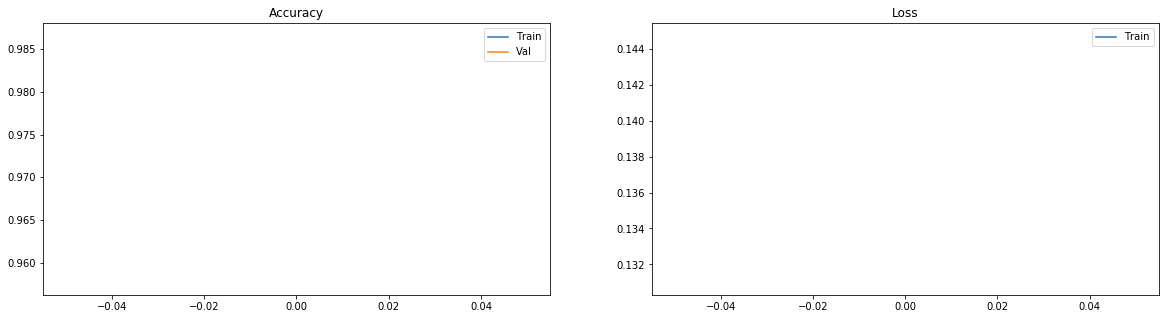

In [14]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(train_history, label='Train')
plt.plot(val_history, label='Val')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(loss_history, label='Train')
plt.title('Loss')
plt.legend();

# Multi-class associator

In [15]:
def train_multiclass_model(model, train_loader, val_loader, loss, optimizer, num_epoch):
    
    loss_history=[]
    accuracy_history=[]
    for epoch in range(num_epoch):
        
        model.train()
        loss_accum=0
        correct_samples=0
        total_samples=0
        correct_samples_total=0
        total_samples_total=0
        
        for i_step, (x,y,y_oh,y_class) in enumerate(train_loader):
            
            y_oh=y_oh.type(torch.FloatTensor)
            #Devide classes into cats/cars and dogs/planes: class_one - with 1 ticker - class_two - with 2
            y_class=list(y_class)
            indexes_one = [i for i,x in enumerate(y_class) if (x == 'pasta')|(x == 'hotdog')] 
            indexes_two = [i for i,x in enumerate(y_class) if (x == 'burger')|(x == 'pizza')] 
                       
            #Calculate loss for 1st part
            x_one=x[indexes_one]
            y_oh_one=y_oh[indexes_one][:,:2]
            x_one, y_oh_one=x_one.to(device), y_oh_one.to(device)      
            
            prediction=model(x_one)
            prediction_one=prediction[:,:2]
            loss_value_one=loss(prediction_one,y_oh_one)

            #Calculate loss for 2nd part
            x_two=x[indexes_two]
            y_oh_two=y_oh[indexes_two][:,:2]
            x_two,y_oh_two=x_two.to(device), y_oh_two.to(device)

            prediction_two=model(x_two)[:,:2]
            loss_value_two=loss(prediction_two,y_oh_two)
            
            #Calculate total loss
            loss_value=(loss_value_one+loss_value_two)/2
            
            #Calculate accuracy of classes 3 and 4 for dogs and planes
            prediction_accuracy=prediction[:,2:]
            _, indices_pred=torch.max(prediction_accuracy,1)
            _, indices_true=torch.max(y_oh_one,1)
            correct_samples+=torch.sum(indices_pred==indices_true)
            total_samples+=indices_pred.shape[0]
            
            #Calculate accuracy of calsses 1 and 2 for all images
            x_total=x
            y_total=y_oh[:,:2]
            x_total, y_total=x_total.to(device),y_total.to(device)
            
            prediction_total=model(x_total)[:,:2]
            _, indices_total_pred=torch.max(prediction_total,1)
            _, indices_total_true=torch.max(y_total,1)
            correct_samples_total+=torch.sum(indices_total_pred==indices_total_true)
            total_samples_total+=indices_total_pred.shape[0]
            
            
            #Optimize model
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
                        
            loss_accum+=loss_value
                    
        scheduler.step()            
        ave_loss=loss_accum/i_step
        
        train_accuracy=float(correct_samples)/total_samples        
        class_accuracy_train=float(correct_samples_total)/total_samples_total
        
        val_accuracy=calculate_accuracy(model,val_loader)
        
        
        accuracy_history.append(train_accuracy)
        loss_history.append(float(ave_loss))
        
        print('Epoch: {}/{}, Loss: {}, Acc_train: {}, Acc_val: {}, Acc: {}'.format(epoch+1,
                  num_epoch,ave_loss, train_accuracy,val_accuracy,class_accuracy_train))
        
    return loss_history, accuracy_history

def calculate_accuracy(model, loader):
    
    model.eval()
    correct_samples=0
    total_samples=0
    for i_step, (x,y,y_oh,y_class) in enumerate(loader):
        indexes_one = [i for i,x in enumerate(y_class) if (x == 'dog')|(x == 'airplane')] 
        y_oh=y_oh.type(torch.FloatTensor)
        y_class=list(y_class)
        x,y=x.to(device)[indexes_one],y_oh.to(device)[indexes_one][:,:2]
        print(x)
        prediction=model(x)[:,2:]
        _, indices_pred=torch.max(prediction,1)
        _, indices_true=torch.max(y,1)
        correct_samples+=torch.sum(indices_pred==indices_true)
        total_samples+=indices_pred.shape[0]
    accuracy=float(correct_samples)/total_samples
    
    return accuracy

In [16]:
# My model

multiclass_net=models.resnet18(pretrained=True)
num_ftrs=multiclass_net.fc.in_features
multiclass_net.fc=(nn.Linear(num_ftrs,4))

multiclass_net.load_state_dict(torch.load('classifier.pt'))
multiclass_net=multiclass_net.to(device)
loss=nn.BCEWithLogitsLoss()
optimizer=optim.SGD(multiclass_net.parameters(),lr=1e-3, momentum=0.9)

loss_history, accuracy_history = train_multiclass_model(multiclass_net, train_loader, val_loader, loss, optimizer, 1)
torch.save(multiclass_net_2.state_dict(), 'multiclass.pt')

RuntimeError: cuDNN error: CUDNN_STATUS_BAD_PARAM